In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

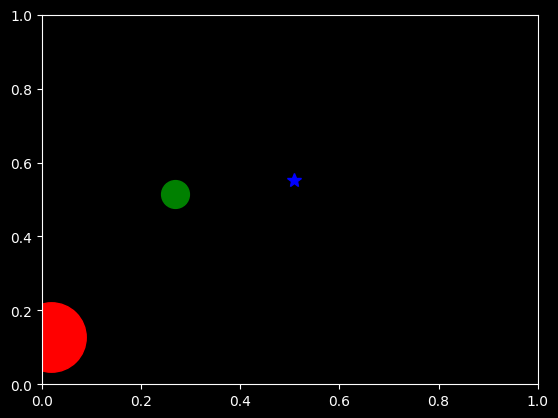

In [2]:
from environment import SimulationEnvironment0

sim = SimulationEnvironment0(num_blackholes=1,force_constant=0.002,velocity_scale=0.01)

from IPython.display import clear_output


for i in range(10):
    actions = torch.rand((1,2))*2-1
    rewards, next_states, is_terminal = sim.step(actions,)
    print(rewards, next_states, is_terminal)
    states = sim.get_state()
    print(states)
    plt.plot(states[0,0,0],states[0,0,1],'b*',markersize=10)      # ship
    plt.plot(states[0,2:,0],states[0,2:,1],'r.',markersize=100)    # black-holes
    plt.plot(states[0,1,0],states[0,1,1],'g.',markersize=40)      # goal
    plt.xlim(0,1)
    plt.ylim(0,1)
    clear_output(wait=True)
    plt.show()
    time.sleep(0.01)

In [3]:
num_blackholes=1
sim = SimulationEnvironment0(num_simulations=128,
                            num_blackholes=num_blackholes, 
                            force_constant=0.002, 
                            velocity_scale=0.01,
                            goal_threshold=0.05,
                            device='cuda')
states = sim.get_state()

In [4]:
from agents import *
import copy

agent = Agent14((num_blackholes+2), 512).cuda()

optim = torch.optim.AdamW(agent.parameters(), lr=3e-4, weight_decay=1e-3)

target_agent = copy.deepcopy(agent)


In [5]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# torch.autograd.set_detect_anomaly(True)# 

In [6]:
from utils import Prioritized_Replay_Buffer, update_target_model

In [7]:
# Inherit from Function
class Activation(torch.autograd.Function):

    # Note that forward, setup_context, and backward are @staticmethods
    @staticmethod
    def forward(ctx,input):
        return torch.softmax(input,-1)

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

tensor(-0.0591)


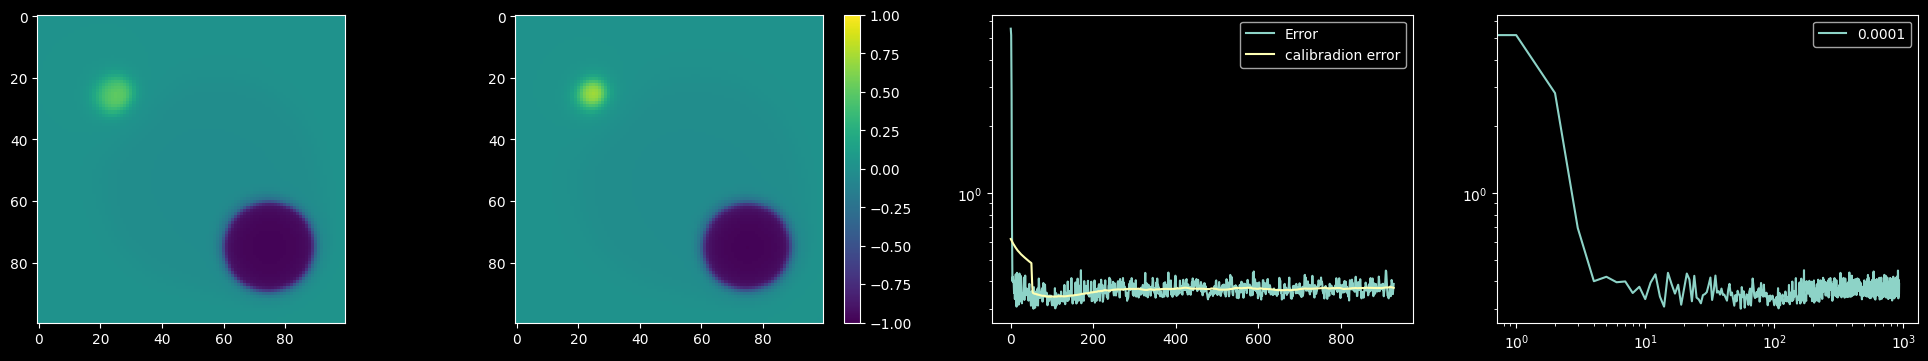

  9%|▉         | 930/10000 [02:19<46:21,  3.26it/s, 29.4      -0.0139   ]

tensor(-0.0105, device='cuda:0')
tensor(-0.0006, device='cuda:0')


  9%|▉         | 932/10000 [02:19<32:13,  4.69it/s, 29.4      -0.0139   ]

tensor(0.0028, device='cuda:0')
tensor(-0.0081, device='cuda:0')


  9%|▉         | 934/10000 [02:20<24:55,  6.06it/s, 29.4      -0.0139   ]

tensor(-0.0064, device='cuda:0')
tensor(-0.0102, device='cuda:0')


  9%|▉         | 936/10000 [02:20<21:11,  7.13it/s, 29.4      -0.0139   ]

tensor(-0.0098, device='cuda:0')
tensor(-0.0101, device='cuda:0')


  9%|▉         | 938/10000 [02:20<19:29,  7.75it/s, 23.5      -0.00679  ]

tensor(-0.0045, device='cuda:0')
tensor(0.0063, device='cuda:0')


  9%|▉         | 940/10000 [02:20<18:43,  8.06it/s, 23.5      -0.00679  ]

tensor(0.0021, device='cuda:0')
tensor(-0.0059, device='cuda:0')


  9%|▉         | 942/10000 [02:21<18:41,  8.08it/s, 23.5      -0.00679  ]

tensor(-0.0012, device='cuda:0')
tensor(-0.0034, device='cuda:0')


  9%|▉         | 944/10000 [02:21<18:31,  8.15it/s, 23.5      -0.00679  ]

tensor(-0.0095, device='cuda:0')
tensor(0.0004, device='cuda:0')


  9%|▉         | 946/10000 [02:21<19:53,  7.59it/s, 29.7      -0.0231   ]

tensor(0.0004, device='cuda:0')
tensor(-0.0089, device='cuda:0')


  9%|▉         | 948/10000 [02:21<19:09,  7.87it/s, 29.7      -0.0231   ]

tensor(0.0009, device='cuda:0')
tensor(-0.0028, device='cuda:0')


  9%|▉         | 949/10000 [02:22<22:35,  6.68it/s, 29.7      -0.0231   ]


tensor(1.4879e-05, device='cuda:0')


KeyboardInterrupt: 

In [10]:
ES = []
CS = []
LR = [1e-4]#1e-3,5e-4,2.5e-4,1e-4


training_steps = int(1e4)
epochs=5
gamma = 0.8
smoothing = 1e-2
focal=1
plot = False

bin_values = (torch.arange(255)-127).cuda()/127*10
bin_values = bin_values.sign()*(bin_values.abs().exp()-1)

for lr in LR:

    agent = Agent14((num_blackholes+2), 512).cuda()
    optim = torch.optim.AdamW(agent.parameters(), lr=lr, weight_decay=1e-3)
    target_agent = copy.deepcopy(agent)

    batch_size = 2**10
    replay_buffer = Prioritized_Replay_Buffer((3,2),(2,), batch_size=batch_size, size=2**14, device='cuda')

    old_states=None

    R=[]

    from tqdm import tqdm
    pbar = tqdm(range(training_steps))

    x,y = torch.meshgrid(torch.arange(100),torch.arange(100))
    pos = torch.stack([x.flatten(), y.flatten()],1)/100
    target_pos = torch.ones_like(pos)*0.25
    bh_pos = torch.ones_like(pos)*0.75

    st=torch.stack([pos,target_pos,bh_pos],1)

    E = []
    C = []


    for i in pbar:
        #gamma = i/training_steps

        # generate experience
        actions, values = agent(states.reshape(states.shape[0],-1).cuda())
        actions = actions.reshape(actions.shape[0],-1,2)
        actions = torch.rand_like(actions)*2-1

        m = actions[:,:,0]
        s = torch.exp(actions[:,:,1])

        sampled_action = m + torch.randn_like(m) * s
        action_prob = torch.exp(-torch.square((sampled_action-m)/s)/2) / (s*np.sqrt(2*np.pi))

        rewards, new_states, is_terminal = sim.step(torch.arctan(sampled_action).detach())

        with torch.inference_mode():
            _, next_values = target_agent(new_states.reshape(new_states.shape[0],-1).cuda())

        expexted_next_value = (torch.softmax(next_values,1)@bin_values[:,None])[:,0]*(is_terminal.logical_not())
        print(expexted_next_value.mean())

        target_value = rewards + gamma*expexted_next_value
        simlog = (target_value.abs()+1).log()*target_value.sign()

        y = torch.zeros(len(simlog), 255, device=rewards.device)
        y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()] = 1-(simlog.clip(-10,10)*127/10+127).frac()
        y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()+1] = (simlog.clip(-10,10)*127/10+127).frac()


        # soft targets
        y = y*(1-smoothing) + torch.ones_like(y)/255*smoothing

        # values = values-values.max(-1)[0][:,None]
        # probs = values.exp()
        # probs = probs/probs.sum(-1,keepdims=True)
        probs = torch.softmax(values,1)

        assert  torch.all((probs + 1e-7)>0), f"{probs[(probs + 1e-7)<=0]}"
        
        critic_error = (- torch.pow(1-probs,focal)* (probs + 1e-7).log() * y ).sum(-1) #torch.nn.functional.cross_entropy(values,y)
        #critic_error = torch.abs(probs-y).mean(-1) 

        error =  critic_error  #* weights # actor_error +

        optim.zero_grad()
        error.mean().backward()
        optim.step()

        replay_buffer.add_experience(states=states, actions=sampled_action, rewards=rewards, next_states=new_states, terminals=is_terminal, weights=critic_error+1e-7)

        C.append((probs-y).mean(0).detach().cpu())
        E.append(critic_error.mean().item())

        
        for epoch in range(epochs):

            for b_idx in range(3):
                b_states, b_actions, b_rewards, b_next_states, b_terminals, weights = replay_buffer.get_high_priority_batch()
                #print((replay_buffer.rewards==1).sum().item(), (b_rewards==1).sum().item())
                #print(weights.max())

                actions, values = agent(b_states.reshape(b_states.shape[0],-1).cuda())
                actions = actions.reshape(actions.shape[0],-1,2)
                m = actions[:,:,0]
                s = torch.exp(actions[:,:,1])
                action_prob = torch.exp(-torch.square((b_actions-m)/s)/2) / (s*np.sqrt(2*np.pi))
                
                with torch.inference_mode():
                    _, next_values = target_agent(b_next_states.reshape(b_next_states.shape[0],-1).cuda())

                
                expexted_next_value = (torch.softmax(next_values,1)@bin_values[:,None])[:,0]*(b_terminals.logical_not())

                target_value = b_rewards + gamma*expexted_next_value
                simlog = (target_value.abs()+1).log()*target_value.sign()
                y = torch.zeros(len(simlog), 255, device=next_values.device)
                y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()] = 1-(simlog.clip(-10,10)*127/10+127).frac()
                y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()+1] = (simlog.clip(-10,10)*127/10+127).frac()

                # soft targets
                y = y*(1-smoothing) + torch.ones_like(y)/255*smoothing

                # values = values-values.max(-1)[0][:,None]
                # probs = values.exp()
                # probs = probs/probs.sum(-1,keepdims=True)
                probs = torch.softmax(values,1)

                assert  torch.all((probs + 1e-7)>0), f"{probs[(probs + 1e-7)<=0]}"

                critic_error = (- torch.pow(1-probs,focal)*(probs + 1e-7).log() * y / weights[:,None] / 255 ).sum(-1) #torch.nn.functional.cross_entropy(values,y)
                #critic_error = torch.abs(probs-y).mean(-1) 

                # pred_error =  b_rewards - values[:,0]#gamma*next_values[:,0]*(1-b_terminals.float()) +

                # critic_error = pred_error.square() #* weights
                # actor_error = -pred_error.detach()*torch.log(action_prob.prod(-1))
                error =  critic_error  #* weights # actor_error +

                optim.zero_grad()
                error.mean().backward()
                optim.step()

                replay_buffer.update_weights(critic_error+1e-7)


        update_target_model(model=agent, target_model=target_agent, decay=1e-2)

        states = new_states

        if i % 8 == 0:
            pbar.set_postfix_str(#f'{pred_error.mean().item():.3g}'.ljust(10)+
                                #f'{actor_error.mean().item():.3g}'.ljust(10)+
                                f'{error.mean().item():.3g}'.ljust(10)+
                                f'{rewards.mean().item():.3g}'.ljust(10))

        R.append(rewards.mean().item())



        if i % (2**5) == 0:

            V = []
            for b in range((len(st)+batch_size-1)//batch_size):
                stb = st[b*batch_size:(b+1)*batch_size]
                _, v1 = agent(stb.reshape(stb.shape[0],-1).cuda())
                #_, v2 = agent2(st.reshape(st.shape[0],-1).cuda())
                V.append(v1)
            V = torch.concat(V,0)

            V_t = []
            for b in range((len(st)+batch_size-1)//batch_size):
                stb = st[b*batch_size:(b+1)*batch_size]
                _, v1 = target_agent(stb.reshape(stb.shape[0],-1).cuda())
                #_, v2 = agent2(st.reshape(st.shape[0],-1).cuda())
                V_t.append(v1)
            V_t = torch.concat(V_t,0)
            
            #plt.plot(V[0].detach().cpu())
            V = (V.softmax(1).detach().cpu() * torch.arange(255)).sum(1) - 127
            V = V/127*10
            V = (V.abs().exp()-1)*V.sign()

            V_t = (V_t.softmax(1).detach().cpu() * torch.arange(255)).sum(1) - 127
            V_t = V_t/127*10
            V_t = (V_t.abs().exp()-1)*V_t.sign()
            #plt.show()
            #print(V.mean())
            #input()
            clear_output()
            print(V.mean())
            plt.figure(figsize=(25,4))
            plt.subplot(1,4,1)
            plt.imshow(V.reshape(100,100),vmin=-1, vmax=1)
            plt.subplot(1,4,2)
            plt.imshow(V_t.reshape(100,100),vmin=-1, vmax=1)
            plt.colorbar()
            plt.subplot(1,4,3)
            plt.plot(E)
            plt.plot(np.convolve(np.array(E), np.ones(100),'same')/np.convolve(np.ones(len(E)), np.ones(100),'same'))
            plt.yscale('log')
            plt.legend(['Error','calibradion error'])
            plt.subplot(1,4,4)
            for es in ES:
                plt.plot(es)
            plt.plot(E)
            plt.legend(LR)
            plt.yscale('log')
            plt.xscale('log')

            plt.show()

    ES.append(np.array(E))

In [ ]:
len(E)

10000

In [ ]:
np.convolve(np.array(E), np.ones(100),'same').shape

(10000,)

In [ ]:
b_rewards[y[:,136].detach().cpu().argmax()]

tensor(-0.0071, device='cuda:0')

In [ ]:
simlog = (b_rewards.abs()+1).log()*b_rewards.sign()
y = torch.zeros(len(simlog), 255, device=next_values.device)
y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()] = 1-(simlog.clip(-10,10)*127/10+127).frac()
y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()+1] = (simlog.clip(-10,10)*127/10+127).frac()


In [ ]:
y[y[:,136].detach().cpu().argmax()]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
probs[:,0].max()

tensor(9.2202e-05, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
np.where(c.mean(0)>0.001)[0]

NameError: name 'c' is not defined

In [ ]:
c[idx.astype(int)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
(b_rewards==1).sum()

tensor(1, device='cuda:0')

In [ ]:
(replay_buffer.rewards==1).sum()

tensor(2, device='cuda:0')

In [ ]:
replay_buffer.weights[replay_buffer.rewards==1].mean()

tensor(1.0272, device='cuda:0')

In [ ]:
replay_buffer.weights[replay_buffer.rewards==0].mean()

tensor(0.1515, device='cuda:0')

In [ ]:
replay_buffer.weights[replay_buffer.rewards.abs()<0.1].mean()

tensor(0.3428, device='cuda:0')

In [ ]:
low=[replay_buffer.rewards.abs()<0.1]
replay_buffer.states[low][replay_buffer.weights[low]==replay_buffer.weights[low].max()], replay_buffer.rewards[low][replay_buffer.weights[low]==replay_buffer.weights[low].max()]

(tensor([[[0.8881, 0.5656],
          [0.9108, 0.6261],
          [0.1643, 0.0593]]], device='cuda:0'),
 tensor([0.0087], device='cuda:0'))

tensor(-0.0381)


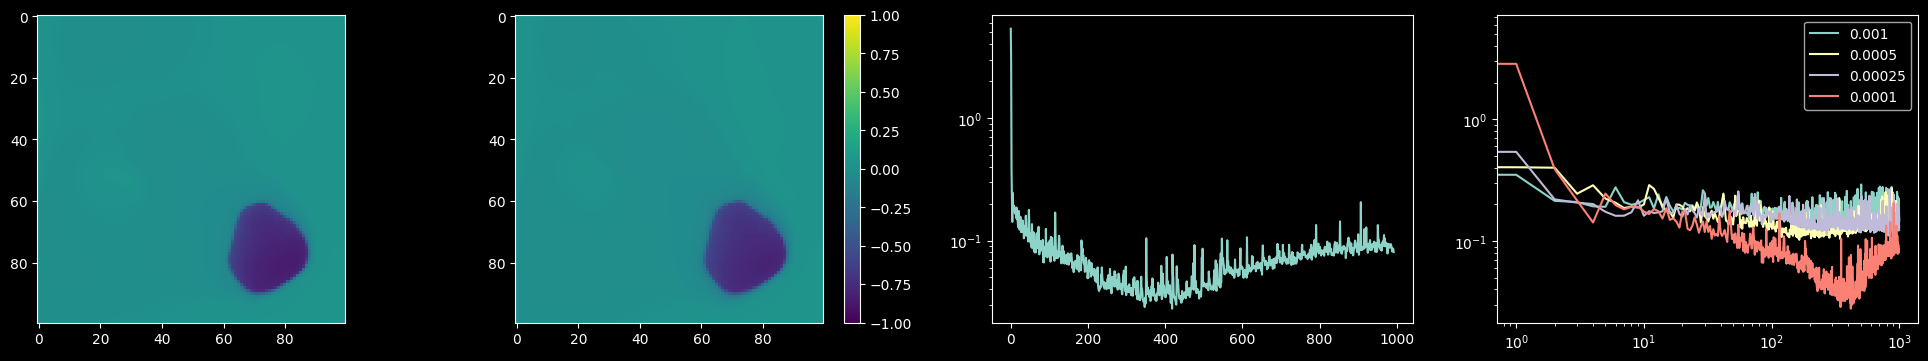

100%|██████████| 1000/1000 [03:05<00:00,  5.39it/s, 0.213     -0.000498 ]


In [ ]:
ES = []
LR = [1e-3, 5e-4, 2.5e-4, 1e-4]

batch_size = 2**7
replay_buffer = Prioritized_Replay_Buffer((3,2),(2,), batch_size=batch_size, size=2**7, device='cuda')

training_steps = int(1e3)
epochs=5
gamma = 0.9
smoothing = 1e-3
focal=2
plot = False

for lr in LR:

    agent = Agent14((num_blackholes+2)*2, 512).cuda()
    optim = torch.optim.AdamW(agent.parameters(), lr=lr, weight_decay=1e-3)
    target_agent = copy.deepcopy(agent)

    batch_size = 2**8
    replay_buffer = Prioritized_Replay_Buffer((3,2),(2,), batch_size=batch_size, size=2**10, device='cuda')

    old_states=None

    R=[]

    from tqdm import tqdm
    pbar = tqdm(range(training_steps))

    x,y = torch.meshgrid(torch.arange(100),torch.arange(100))
    pos = torch.stack([x.flatten(), y.flatten()],1)/100
    target_pos = torch.ones_like(pos)*0.25
    bh_pos = torch.ones_like(pos)*0.75

    st=torch.stack([pos,target_pos,bh_pos],1)

    E = []



    for i in pbar:

        # generate experience
        with torch.inference_mode():
            actions, values = agent(states.reshape(states.shape[0],-1).cuda())
            actions = actions.reshape(actions.shape[0],-1,2)

            m = actions[:,:,0]
            s = torch.exp(actions[:,:,1])

            sampled_action = m + torch.randn_like(m) * s
            action_prob = torch.exp(-torch.square((sampled_action-m)/s)/2) / (s*np.sqrt(2*np.pi))

            rewards, new_states, is_terminal = sim.step(torch.arctan(sampled_action).detach())

            replay_buffer.add_experience(states=states, actions=sampled_action, rewards=rewards, next_states=new_states, terminals=is_terminal)
    
            simlog = (rewards.abs()+1).log()*rewards.sign()
            y = torch.zeros(len(simlog), 255, device=rewards.device)
            y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()] = 1-(simlog.clip(-10,10)*127/10+127).frac()
            y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()+1] = (simlog.clip(-10,10)*127/10+127).frac()


            # soft targets
            y = y*(1-smoothing) + torch.ones_like(y)/255*smoothing

            values = values-values.max(-1)[0][:,None]
            probs = values.exp()
            probs = probs/probs.sum(-1,keepdims=True)
            w = 1 / (y.mean(0) + 1e-7) / 255
            assert  torch.all((probs + 1e-7)>0), f"{probs[(probs + 1e-7)<=0]}"
            critic_error = (- torch.pow(1-probs,focal)* (probs + 1e-7).log() * y).sum(-1) #torch.nn.functional.cross_entropy(values,y)
            E.append(critic_error.mean().item())

        if replay_buffer.elems >= replay_buffer.size:
            
            replay_buffer.shuffle()

        for epoch in range(epochs):
            #print(len(replay_buffer))

            for b_idx in range(min(len(replay_buffer),0)):

                b_states, b_actions, b_rewards, b_next_states, b_terminals, weights = replay_buffer.get(b_idx)
                #print(weights.max())

                actions, values = agent(b_states.reshape(b_states.shape[0],-1).cuda())
                #actions2, values2 = agent2(b_states.reshape(b_states.shape[0],-1).cuda())
                actions = actions.reshape(actions.shape[0],-1,2)
                m = actions[:,:,0]
                s = torch.exp(actions[:,:,1])
                action_prob = torch.exp(-torch.square((b_actions-m)/s)/2) / (s*np.sqrt(2*np.pi))
                
                with torch.inference_mode():
                    _, next_values = agent(b_next_states.reshape(b_next_states.shape[0],-1).cuda())
                # _, next_values2 = agent2(b_next_states.reshape(b_next_states.shape[0],-1).cuda())

                simlog = (b_rewards.abs()+1).log()*b_rewards.sign()
                y = torch.zeros(len(simlog), 255, device=next_values.device)
                y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()] = 1-(simlog.clip(-10,10)*127/10+127).frac()
                y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()+1] = (simlog.clip(-10,10)*127/10+127).frac()


                # soft targets
                y = y*(1-smoothing) + torch.ones_like(y)/255*smoothing

                values = values-values.max(-1)[0][:,None]
                probs = values.exp()
                probs = probs/probs.sum(-1,keepdims=True)
                w = 1 / (y.mean(0) + 1e-7) / 255
                assert  torch.all((probs + 1e-7)>0), f"{probs[(probs + 1e-7)<=0]}"
                critic_error = (- torch.pow(1-probs,focal)* (probs + 1e-7).log() * y).sum(-1) #torch.nn.functional.cross_entropy(values,y)
                E.append(critic_error.mean().item())
                # pred_error =  b_rewards - values[:,0]#gamma*next_values[:,0]*(1-b_terminals.float()) +
                # #pred_error2 =  b_rewards - values2[:,0]
                # critic_error = pred_error.square()  #+ pred_error2.square()


                #actor_error = -pred_error.detach()*torch.log(action_prob.prod(-1))
                error =  critic_error #* weights # actor_error +

                optim.zero_grad()
                error.mean().backward()
                optim.step()

                replay_buffer.update_weights(critic_error+1e-10)

            

            # print((b_rewards==1).sum())
            for b_idx in range(5):
                b_states, b_actions, b_rewards, b_next_states, b_terminals, weights = replay_buffer.get_high_priority_batch()
                #print(weights.max())

                actions, values = agent(b_states.reshape(b_states.shape[0],-1).cuda())
                actions = actions.reshape(actions.shape[0],-1,2)
                m = actions[:,:,0]
                s = torch.exp(actions[:,:,1])
                action_prob = torch.exp(-torch.square((b_actions-m)/s)/2) / (s*np.sqrt(2*np.pi))
                
                with torch.inference_mode():
                    _, next_values = agent(b_next_states.reshape(b_next_states.shape[0],-1).cuda())

                simlog = (b_rewards.abs()+1).log()*b_rewards.sign()
                y = torch.zeros(len(simlog), 255, device=next_values.device)
                y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()] = 1-(simlog.clip(-10,10)*127/10+127).frac()
                y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()+1] = (simlog.clip(-10,10)*127/10+127).frac()

                # soft targets
                y = y*(1-smoothing) + torch.ones_like(y)/255*smoothing

                values = values-values.max(-1)[0][:,None]
                probs = values.exp()
                probs = probs/probs.sum(-1,keepdims=True)
                w = 1 / (y.mean(0) + 1e-7) / 255
                assert  torch.all((probs + 1e-7)>0), f"{probs[(probs + 1e-7)<=0]}"
                critic_error = (- torch.pow(1-probs,focal)*(probs + 1e-7).log() * y).sum(-1) #torch.nn.functional.cross_entropy(values,y)


                # pred_error =  b_rewards - values[:,0]#gamma*next_values[:,0]*(1-b_terminals.float()) +

                # critic_error = pred_error.square() #* weights
                # actor_error = -pred_error.detach()*torch.log(action_prob.prod(-1))
                error =  critic_error  #* weights # actor_error +

                optim.zero_grad()
                error.mean().backward()
                optim.step()

                replay_buffer.update_weights(critic_error+1e-10)

            
            update_target_model(model=agent, target_model=target_agent, decay=0.01)

        states = new_states

        if i % 8 == 0:
            pbar.set_postfix_str(#f'{pred_error.mean().item():.3g}'.ljust(10)+
                                #f'{actor_error.mean().item():.3g}'.ljust(10)+
                                f'{error.mean().item():.3g}'.ljust(10)+
                                f'{rewards.mean().item():.3g}'.ljust(10))

        R.append(rewards.mean().item())



        if i % (2**5) == 0:

            V = []
            for b in range((len(st)+batch_size-1)//batch_size):
                stb = st[b*batch_size:(b+1)*batch_size]
                _, v1 = agent(stb.reshape(stb.shape[0],-1).cuda())
                #_, v2 = agent2(st.reshape(st.shape[0],-1).cuda())
                V.append(v1)
            V = torch.concat(V,0)

            V_t = []
            for b in range((len(st)+batch_size-1)//batch_size):
                stb = st[b*batch_size:(b+1)*batch_size]
                _, v1 = target_agent(stb.reshape(stb.shape[0],-1).cuda())
                #_, v2 = agent2(st.reshape(st.shape[0],-1).cuda())
                V_t.append(v1)
            V_t = torch.concat(V_t,0)
            
            #plt.plot(V[0].detach().cpu())
            V = (V.softmax(1).detach().cpu() * torch.arange(255)).sum(1) - 127
            V = V/127*10
            V = (V.abs().exp()-1)*V.sign()

            V_t = (V_t.softmax(1).detach().cpu() * torch.arange(255)).sum(1) - 127
            V_t = V_t/127*10
            V_t = (V_t.abs().exp()-1)*V_t.sign()
            #plt.show()
            #print(V.mean())
            #input()
            clear_output()
            print(V.mean())
            plt.figure(figsize=(25,4))
            plt.subplot(1,4,1)
            plt.imshow(V.reshape(100,100),vmin=-1, vmax=1)
            plt.subplot(1,4,2)
            plt.imshow(V_t.reshape(100,100),vmin=-1, vmax=1)
            plt.colorbar()
            plt.subplot(1,4,3)
            plt.plot(E)
            plt.yscale('log')
            plt.subplot(1,4,4)
            for es in ES:
                plt.plot(es)
            plt.plot(E)
            plt.legend(LR)
            plt.yscale('log')
            plt.xscale('log')
            plt.show()

    ES.append(np.array(E))

tensor(-0.1010)


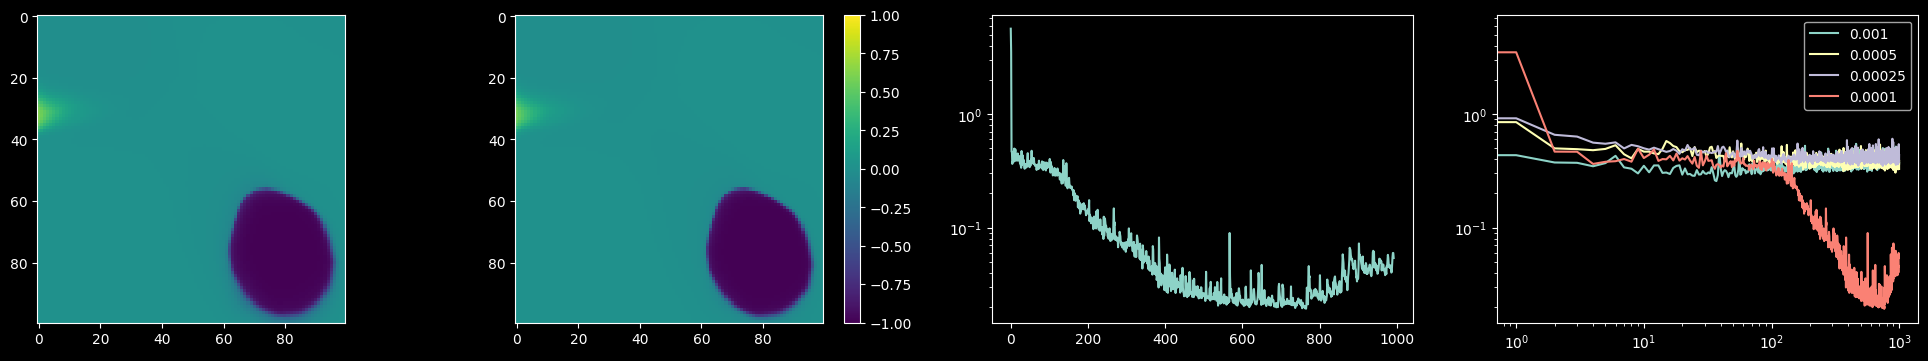

100%|██████████| 1000/1000 [03:53<00:00,  4.29it/s, 0.396     -6.68e-05 ]


In [ ]:
ES = []
LR = [1e-3, 5e-4, 2.5e-4, 1e-4]

training_steps = int(1e3)
epochs=5
gamma = 0.9
smoothing = 1e-3
focal=0
plot = False

for lr in LR:

    agent = Agent14((num_blackholes+2)*2, 512).cuda()
    optim = torch.optim.AdamW(agent.parameters(), lr=lr, weight_decay=1e-3)
    target_agent = copy.deepcopy(agent)

    batch_size = 2**8
    replay_buffer = Prioritized_Replay_Buffer((3,2),(2,), batch_size=batch_size, size=2**10, device='cuda')

    old_states=None

    R=[]

    from tqdm import tqdm
    pbar = tqdm(range(training_steps))

    x,y = torch.meshgrid(torch.arange(100),torch.arange(100))
    pos = torch.stack([x.flatten(), y.flatten()],1)/100
    target_pos = torch.ones_like(pos)*0.25
    bh_pos = torch.ones_like(pos)*0.75

    st=torch.stack([pos,target_pos,bh_pos],1)

    E = []



    for i in pbar:

        # generate experience
        with torch.inference_mode():
            actions, values = agent(states.reshape(states.shape[0],-1).cuda())
            actions = actions.reshape(actions.shape[0],-1,2)

            m = actions[:,:,0]
            s = torch.exp(actions[:,:,1])

            sampled_action = m + torch.randn_like(m) * s
            action_prob = torch.exp(-torch.square((sampled_action-m)/s)/2) / (s*np.sqrt(2*np.pi))

            rewards, new_states, is_terminal = sim.step(torch.arctan(sampled_action).detach())

            replay_buffer.add_experience(states=states, actions=sampled_action, rewards=rewards, next_states=new_states, terminals=is_terminal)
    
            simlog = (rewards.abs()+1).log()*rewards.sign()
            y = torch.zeros(len(simlog), 255, device=rewards.device)
            y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()] = 1-(simlog.clip(-10,10)*127/10+127).frac()
            y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()+1] = (simlog.clip(-10,10)*127/10+127).frac()


            # soft targets
            y = y*(1-smoothing) + torch.ones_like(y)/255*smoothing

            values = values-values.max(-1)[0][:,None]
            probs = values.exp()
            probs = probs/probs.sum(-1,keepdims=True)
            w = 1 / (y.mean(0) + 1e-7) / 255
            assert  torch.all((probs + 1e-7)>0), f"{probs[(probs + 1e-7)<=0]}"
            critic_error = (- torch.pow(1-probs,focal)* (probs + 1e-7).log() * y).sum(-1) #torch.nn.functional.cross_entropy(values,y)
            E.append(critic_error.mean().item())

        if replay_buffer.elems >= replay_buffer.size:
            
            replay_buffer.shuffle()

        for epoch in range(epochs):
            #print(len(replay_buffer))

            for b_idx in range(min(len(replay_buffer),0)):

                b_states, b_actions, b_rewards, b_next_states, b_terminals, weights = replay_buffer.get(b_idx)
                #print(weights.max())

                actions, values = agent(b_states.reshape(b_states.shape[0],-1).cuda())
                #actions2, values2 = agent2(b_states.reshape(b_states.shape[0],-1).cuda())
                actions = actions.reshape(actions.shape[0],-1,2)
                m = actions[:,:,0]
                s = torch.exp(actions[:,:,1])
                action_prob = torch.exp(-torch.square((b_actions-m)/s)/2) / (s*np.sqrt(2*np.pi))
                
                with torch.inference_mode():
                    _, next_values = agent(b_next_states.reshape(b_next_states.shape[0],-1).cuda())
                # _, next_values2 = agent2(b_next_states.reshape(b_next_states.shape[0],-1).cuda())

                simlog = (b_rewards.abs()+1).log()*b_rewards.sign()
                y = torch.zeros(len(simlog), 255, device=next_values.device)
                y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()] = 1-(simlog.clip(-10,10)*127/10+127).frac()
                y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()+1] = (simlog.clip(-10,10)*127/10+127).frac()


                # soft targets
                y = y*(1-smoothing) + torch.ones_like(y)/255*smoothing

                values = values-values.max(-1)[0][:,None]
                probs = values.exp()
                probs = probs/probs.sum(-1,keepdims=True)
                w = 1 / (y.mean(0) + 1e-7) / 255
                assert  torch.all((probs + 1e-7)>0), f"{probs[(probs + 1e-7)<=0]}"
                critic_error = (- torch.pow(1-probs,focal)* (probs + 1e-7).log() * y).sum(-1) #torch.nn.functional.cross_entropy(values,y)
                E.append(critic_error.mean().item())
                # pred_error =  b_rewards - values[:,0]#gamma*next_values[:,0]*(1-b_terminals.float()) +
                # #pred_error2 =  b_rewards - values2[:,0]
                # critic_error = pred_error.square()  #+ pred_error2.square()


                #actor_error = -pred_error.detach()*torch.log(action_prob.prod(-1))
                error =  critic_error #* weights # actor_error +

                optim.zero_grad()
                error.mean().backward()
                optim.step()

                replay_buffer.update_weights(critic_error+1e-10)

            

            # print((b_rewards==1).sum())
            for b_idx in range(5):
                b_states, b_actions, b_rewards, b_next_states, b_terminals, weights = replay_buffer.get_high_priority_batch()
                #print(weights.max())

                actions, values = agent(b_states.reshape(b_states.shape[0],-1).cuda())
                actions = actions.reshape(actions.shape[0],-1,2)
                m = actions[:,:,0]
                s = torch.exp(actions[:,:,1])
                action_prob = torch.exp(-torch.square((b_actions-m)/s)/2) / (s*np.sqrt(2*np.pi))
                
                with torch.inference_mode():
                    _, next_values = agent(b_next_states.reshape(b_next_states.shape[0],-1).cuda())

                simlog = (b_rewards.abs()+1).log()*b_rewards.sign()
                y = torch.zeros(len(simlog), 255, device=next_values.device)
                y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()] = 1-(simlog.clip(-10,10)*127/10+127).frac()
                y[torch.arange(len(simlog), dtype=torch.long),(simlog.clip(-10,10)*127/10+127).floor().long()+1] = (simlog.clip(-10,10)*127/10+127).frac()

                # soft targets
                y = y*(1-smoothing) + torch.ones_like(y)/255*smoothing

                values = values-values.max(-1)[0][:,None]
                probs = values.exp()
                probs = probs/probs.sum(-1,keepdims=True)
                w = 1 / (y.mean(0) + 1e-7) / 255
                assert  torch.all((probs + 1e-7)>0), f"{probs[(probs + 1e-7)<=0]}"
                critic_error = (- torch.pow(1-probs,focal)*(probs + 1e-7).log() * y).sum(-1) #torch.nn.functional.cross_entropy(values,y)


                # pred_error =  b_rewards - values[:,0]#gamma*next_values[:,0]*(1-b_terminals.float()) +

                # critic_error = pred_error.square() #* weights
                # actor_error = -pred_error.detach()*torch.log(action_prob.prod(-1))
                error =  critic_error  #* weights # actor_error +

                optim.zero_grad()
                error.mean().backward()
                optim.step()

                replay_buffer.update_weights(critic_error+1e-10)

            
            update_target_model(model=agent, target_model=target_agent, decay=0.01)

        states = new_states

        if i % 8 == 0:
            pbar.set_postfix_str(#f'{pred_error.mean().item():.3g}'.ljust(10)+
                                #f'{actor_error.mean().item():.3g}'.ljust(10)+
                                f'{error.mean().item():.3g}'.ljust(10)+
                                f'{rewards.mean().item():.3g}'.ljust(10))

        R.append(rewards.mean().item())



        if i % (2**5) == 0:

            V = []
            for b in range((len(st)+batch_size-1)//batch_size):
                stb = st[b*batch_size:(b+1)*batch_size]
                _, v1 = agent(stb.reshape(stb.shape[0],-1).cuda())
                #_, v2 = agent2(st.reshape(st.shape[0],-1).cuda())
                V.append(v1)
            V = torch.concat(V,0)

            V_t = []
            for b in range((len(st)+batch_size-1)//batch_size):
                stb = st[b*batch_size:(b+1)*batch_size]
                _, v1 = target_agent(stb.reshape(stb.shape[0],-1).cuda())
                #_, v2 = agent2(st.reshape(st.shape[0],-1).cuda())
                V_t.append(v1)
            V_t = torch.concat(V_t,0)
            
            #plt.plot(V[0].detach().cpu())
            V = (V.softmax(1).detach().cpu() * torch.arange(255)).sum(1) - 127
            V = V/127*10
            V = (V.abs().exp()-1)*V.sign()

            V_t = (V_t.softmax(1).detach().cpu() * torch.arange(255)).sum(1) - 127
            V_t = V_t/127*10
            V_t = (V_t.abs().exp()-1)*V_t.sign()
            #plt.show()
            #print(V.mean())
            #input()
            clear_output()
            print(V.mean())
            plt.figure(figsize=(25,4))
            plt.subplot(1,4,1)
            plt.imshow(V.reshape(100,100),vmin=-1, vmax=1)
            plt.subplot(1,4,2)
            plt.imshow(V_t.reshape(100,100),vmin=-1, vmax=1)
            plt.colorbar()
            plt.subplot(1,4,3)
            plt.plot(E)
            plt.yscale('log')
            plt.subplot(1,4,4)
            for es in ES:
                plt.plot(es)
            plt.plot(E)
            plt.legend(LR)
            plt.yscale('log')
            plt.xscale('log')
            plt.show()

    ES.append(np.array(E))